**Select TPU or GPU**

Here, I used TPU from Google Colab. Set the runtime type from: `Runtime > Change runtime type > TPU`

**Setup**
- Mount the notebook to Google Drive: `%cd /content/drive/MyDrive/`
- Download SQUAD data.
- Install required packages

In [1]:
%cd /content/drive/MyDrive/

!mkdir squad
!wget -q https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad/train-v2.0.json
!wget -q https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad/dev-v2.0.json

!pip install -q -U transformers transformers[torch] accelerate

# For TPU
!pip install -q -U cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

# For GPU
#!pip install -q -U cloud-tpu-client==0.10 torch==2.0.0  torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/cuda/117/torch_xla-2.0-cp39-cp39-linux_x86_64.whl --force-reinstall

/content/drive/MyDrive
mkdir: cannot create directory ‘squad’: File exists


**Imports**

In [2]:
import json
import torch
import torch_xla
import torch_xla.core.xla_model as xm
from torch.utils.data import Dataset
from transformers import TrainingArguments, Trainer, GPT2LMHeadModel, GPT2Tokenizer, AutoTokenizer

**Load Data**

In [3]:
def get_data(filepath):
    """Retrieve questions, answers, and contexts from the given SQuAD filepath."""
    with open(filepath, 'rb') as f:
        squad = json.load(f)

    questions, answers, contexts, start_positions, end_positions = [], [], [], [], []
    for data in squad["data"]:
        for paragraph in data["paragraphs"]:
            context = paragraph["context"]
            for qa in paragraph["qas"]:
                question = qa["question"]
                for answer in qa["answers"]:
                    questions.append(question)
                    answers.append(answer["text"])
                    contexts.append(context)
                    start_positions.append(answer["answer_start"])
                    end_positions.append(answer["answer_start"] + len(answer["text"]))
    return questions, answers, contexts, start_positions, end_positions

tr_questions, tr_answers, tr_contexts, tr_start_positions, tr_end_positions = get_data("squad/train-v2.0.json")
vl_questions, vl_answers, vl_contexts, vl_start_positions, vl_end_positions = get_data("squad/dev-v2.0.json")


**Setup Model**

In [4]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = xm.xla_device()

model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
model.to(device)

# tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

**Process Data**

In [5]:
# Merge question and context, and set up the model to generate the answer
merged_texts = ["Question: " + q + " Context: " + c for q, c in zip(tr_questions[:100], tr_contexts[:100])]
tr_tokens = tokenizer(merged_texts, return_tensors="pt", padding='max_length', truncation=True, max_length=512)
labels = tokenizer(tr_answers[:100], return_tensors="pt", padding='max_length', truncation=True, max_length=512).input_ids
tr_tokens['labels'] = labels


merged_texts = ["Question: " + q + " Context: " + c for q, c in zip(vl_questions[:10], vl_contexts[:10])]
vl_tokens = tokenizer(merged_texts, return_tensors="pt", padding='max_length', truncation=True, max_length=512)
labels = tokenizer(tr_answers[:10], return_tensors="pt", padding='max_length', truncation=True, max_length=512).input_ids
vl_tokens['labels'] = labels

In [6]:
class CustomDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Create datasets
train_dataset = CustomDataset(tr_tokens)
valid_dataset = CustomDataset(vl_tokens)

**Training**

In [7]:
# Training parameters
output_folder = model_name
num_train_epochs = 5
train_batch_size = 4
steps_per_epoch = len(train_dataset) // train_batch_size

training_args = TrainingArguments(
    output_dir=f"./{output_folder}/results",
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=train_batch_size,
    logging_dir=f"./{output_folder}/logs",
    logging_steps=steps_per_epoch,    # Log at the end of each epoch
    evaluation_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
)

# Fine-tune the model
trainer.train()


<ipython-input-6-c32b080c291b>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,0.940700,0.043123
2,0.039800,0.034073
3,0.035700,0.030353
4,0.032700,0.028327
5,0.030800,0.027835


TrainOutput(global_step=125, training_loss=0.21592948722839356, metrics={'train_runtime': 41.2214, 'train_samples_per_second': 12.13, 'train_steps_per_second': 3.032, 'total_flos': 130646016000000.0, 'train_loss': 0.21592948722839356, 'epoch': 5.0})

**Visualize Training and Validation Errors**

['train/loss', 'train/learning_rate', 'train/epoch', 'eval/loss', 'eval/runtime', 'eval/samples_per_second', 'eval/steps_per_second', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']


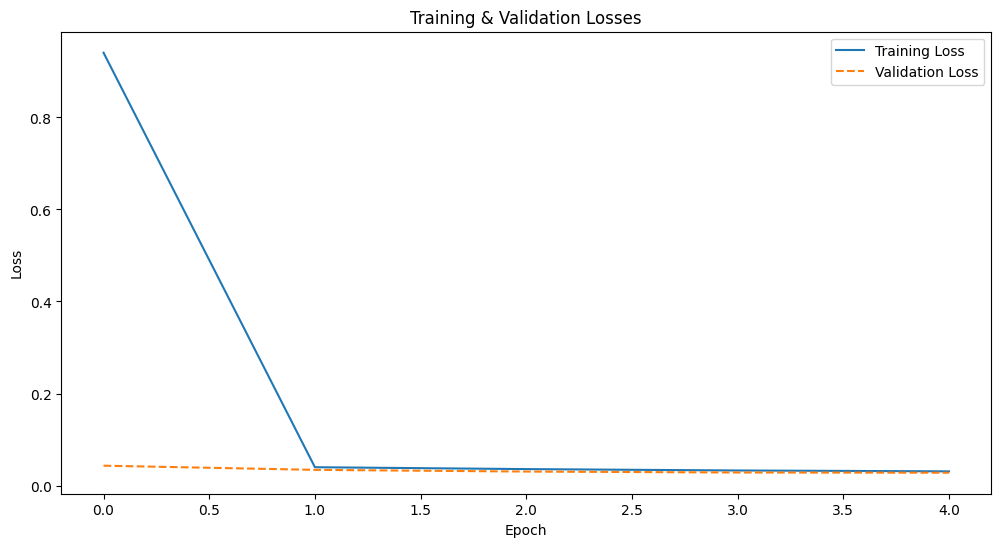

In [8]:
import os
import tensorflow as tf
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

log_dir = f"./{output_folder}/logs"  # Adjust if your log directory is different
log_files = [file for file in os.listdir(log_dir) if 'tfevents' in file]

training_losses = []
validation_losses = []

# Assuming just one event file, you can loop through or modify this if there are more
event_acc = EventAccumulator(os.path.join(log_dir, log_files[0]))
event_acc.Reload()

# available_keys = event_acc.Tags()['scalars']
# print(available_keys)

# Extract training and validation losses
for event in event_acc.Scalars('train/loss'):
    training_losses.append(event.value)

for event in event_acc.Scalars('eval/loss'):
    validation_losses.append(event.value)

plt.figure(figsize=(12, 6))
plt.plot(training_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Losses")
plt.show()

**Save Model and Tokenizer**

In [9]:
# Save model and tokenizer
model_save_path = f"./{output_folder}/models"
tokenizer_save_path = f"./{output_folder}/tokenizer"

model.save_pretrained(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)


('./gpt2/tokenizer/tokenizer_config.json',
 './gpt2/tokenizer/special_tokens_map.json',
 './gpt2/tokenizer/vocab.json',
 './gpt2/tokenizer/merges.txt',
 './gpt2/tokenizer/added_tokens.json',
 './gpt2/tokenizer/tokenizer.json')

**Load Model and Tokenizer**

In [10]:
# Load saved model and tokenizer
loaded_model = GPT2LMHeadModel.from_pretrained(model_save_path)
loaded_tokenizer = AutoTokenizer.from_pretrained(tokenizer_save_path)

**Generate Response using the Fine-tuned Model**

In [32]:
import torch_xla.core.xla_model as xm

device = xm.xla_device()
loaded_model = loaded_model.to(device)

def generate_response(question, context):
    # Combine the question and context
    input_text = "Answer the following: " + question + " Given that, " + context

    # Tokenize the input text
    input_ids = loaded_tokenizer.encode(input_text, return_tensors="pt")

    # Move input_ids to the TPU device
    input_ids = input_ids.to(device)

    # Generate a response with the model
    output = loaded_model.generate(input_ids,
                                   max_length=512,
                                   num_return_sequences=1,
                                   pad_token_id=loaded_tokenizer.eos_token_id,
                                   top_k=50)

    # Decode and return the model's output
    response = loaded_tokenizer.decode(output[0], skip_special_tokens=True)
    response = response[(len(input_text)-len(context)):]
    return response

**Use the function to get a response**

In [33]:
question = "What is the capital of France?"
context = "The capital of France is Paris, a major European city and a global center for art, fashion, and culture."
print(generate_response(question, context))

The capital of France is Paris, a major European city and a global center for art, fashion, and culture.
